# A High-Level Overview of the Representation Toolbox

In this overview, we will explore different options for representing acoustic signals. This is an important consideration when constructing a machine learning (ML) pipeline, since we want to provide our networks with inputs that are as meaningful as possible. For this project, we'll use a tonal orca call and a transient sperm whale click.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import soundfile as sf
from IPython.display import Audio

from fastai2.vision.all import *

In [2]:
path = untar_data('https://storage.googleapis.com/ml-bioacoustics-datasets/orchive-dataset.tar.gz')

In [3]:
call_path = Path('../../.fastai/data/orchive-dataset.tar/call-catalog-xsilence/N01')
file_path = call_path.ls()[0]

In [4]:
class Labelling(object):
    
    def __init__(self, path):
        self.path=path
        
    def get_path_name(self):
        return str(self.path)
    
    def get_aiff_name(self):
        path_name = self.get_path_name()
        return path_name.split('/')[-1]
    
    def gen_label(self):
        aiff_name = self.get_aiff_name()
        label = aiff_name.split('-')[0] + '-' + aiff_name.split('-')[1]
        return label
    
    def get_matriline(self):
        label = self.gen_label()
        return label.split('-')[0]
    
    def get_call_type(self):
        label = self.gen_label()
        return label.split('-')[1]
        
    
labeller = Labelling(file_path)
print(f'Original Path: {labeller.get_path_name()}')
print(f'File Name: {labeller.get_aiff_name()}')
print(f'Signal Label: {labeller.gen_label()}')
print(f'Matriline: {labeller.get_matriline()}')
print(f'Call Type: {labeller.get_call_type()}')

Original Path: ../../.fastai/data/orchive-dataset.tar/call-catalog-xsilence/N01/A36-N01-062802-D004-12218.aiff
File Name: A36-N01-062802-D004-12218.aiff
Signal Label: A36-N01
Matriline: A36
Call Type: N01


Now that we've loaded the orca data, let's see what it sounds like.

In [5]:
labeller = Labelling(file_path)
path_name = labeller.get_path_name()
data_orca, sample_rate_orca = sf.read(path_name)
Audio(data_orca, rate=sample_rate_orca)

Now for the sperm whale clicks:

In [6]:
file = 'data/WatkinsPMacro.wav'
data_sw, sample_rate_sw = sf.read(file)
Audio(data_sw, rate=sample_rate_sw)

Ok great! But for the purposes of this presentation, we'll focus on a single click:

In [7]:
click_sw = data_sw[31000:37500]
Audio(click_sw, rate=sample_rate_sw)

# Time and Frequency Space Representations

Here, we will plot the original signal in both the time and frequency domains. we are employing a mathematical technique called a discrete Fourier transform (DFT) to convert from the time domain to the frequency domain, and we make use of the fast Fourier transform (FFT) algorithm to compute the transform quickly and efficiently.

In [8]:
from scipy.fft import fft

In [9]:
def plot_t_and_f_reps(signal, fs, lw=0.1, fmax=6e3):
    N = len(signal)
    delta_t = 1 / fs
    times = np.arange(0, N) / fs
    signalf = fft(signal)
    freqs = np.linspace(0.0, 1.0/(2.0*delta_t), N//2)
    
    fig, axs = plt.subplots(1,2, figsize=(20,5))
    axs[0].plot(times, signal, linewidth=lw)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_title('Time Domain Representation')
    
    axs[1].plot(freqs, 2.0/N * np.abs(signalf[0:N//2]), linewidth=0.4)
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Amplitude')
    axs[1].set_title('Frequency Domain Representation')
    axs[1].set_xlim([0, fmax])
    
    plt.show()

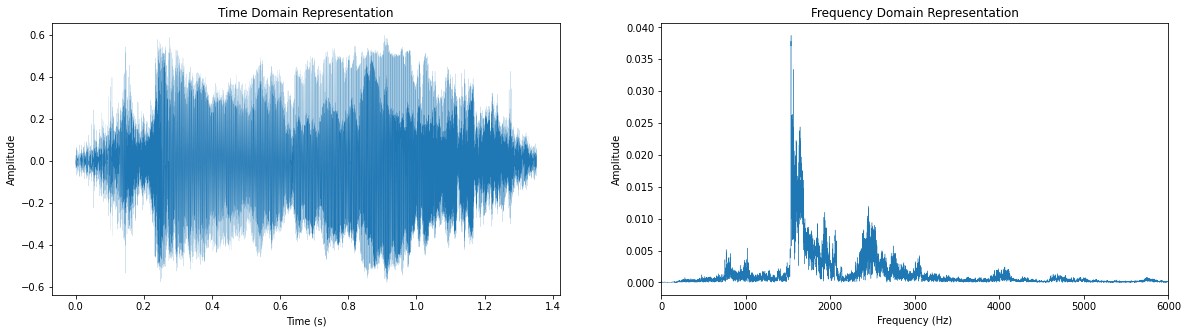

In [10]:
plot_t_and_f_reps(data_orca, sample_rate_orca)

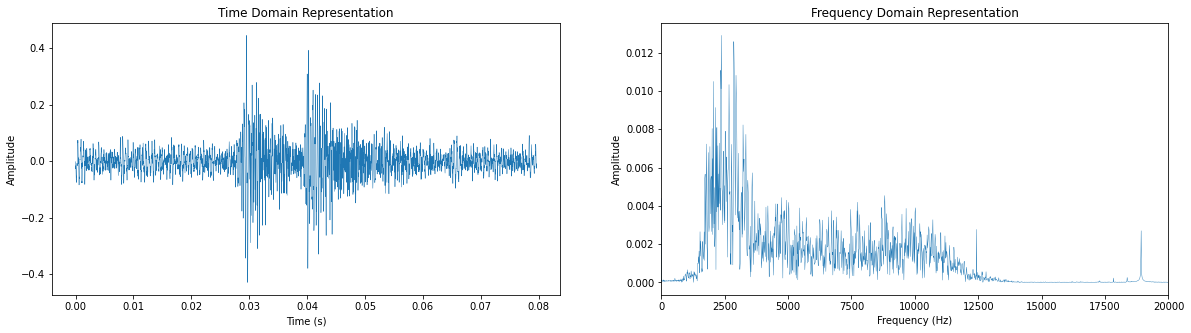

In [11]:
plot_t_and_f_reps(data_sw[31000:37500], sample_rate_sw, lw=0.5, fmax=2e4)

While these raw audio representation can be directly used as inputs, it's often helpful to carry out feature engineering in order to transform to fime-frequency representations.

# Spectrograms

A conventional approach for transforming 1-dimensional acoustic signals into 2-dimensional 'images' is through the construction of a spectrogram. The process of generating a spectrogram requires splitting the signal into overlapping segments and applying the Fourier transform to these windows. This is called the short time Fourier transform (STFT). Let's see what our orca signal looks like.

In [12]:
from scipy.signal import spectrogram

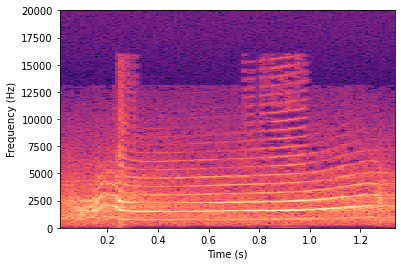

In [13]:
f_bins, t_bins, Sxx = spectrogram(data_orca, fs=sample_rate_orca,
                                 window='hanning', nperseg=1024,
                                 noverlap=1024-512, detrend=False,
                                 scaling='spectrum')
plt.pcolormesh(t_bins, f_bins, 20*np.log10(Sxx+1e-100), cmap='magma')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylim([0, 2e4])
plt.show()

However, there are many parameters to consider when constructing spectrograms. To begin unpacking the numerous options, we start by considering the uncertainty principle, which tells us that there is a tradeoff between time resolution and frequency resolution, since we can't simultaneously minimize both. The parameter ``nperseg`` yields insights into these resolutions. 

Using ``nperseg=1024`` with a sample rate of 44.1 kHz leads to a window length (temporal resolution) of 

$$ \frac{1024}{44100} = 0.023 \text{s} $$

and a frequency resolution of 

$$ \frac{44100}{1024} = 43.1 \text{Hz}$$

This tells us that all else equal, increasing ``nperseg`` improves frequency resolution but impairs temporal resolution. This is demonstrated in the following plot.

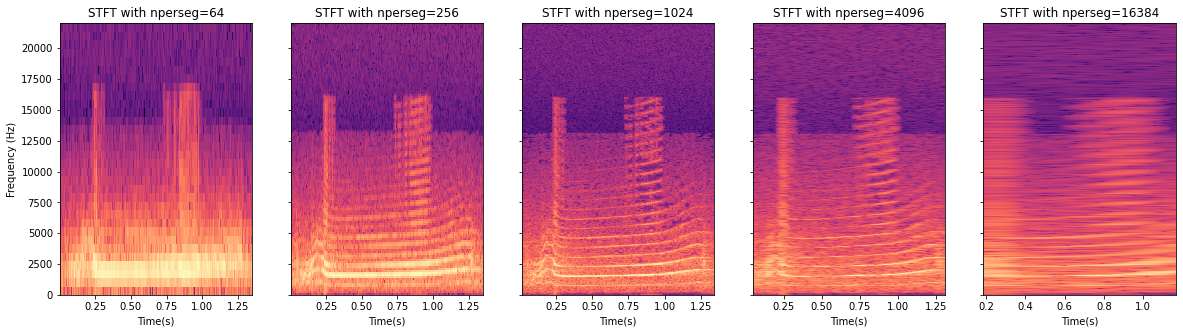

In [14]:
npersegs = [64, 256, 1024, 4096, 16384]
fig, axs = plt.subplots(1, len(npersegs), sharey=True, figsize=(20,5))
axs[0].set_ylabel('Frequency (Hz)')

for i, window_length in enumerate(npersegs):
    f_bins, t_bins, Sxx = spectrogram(data_orca, fs=sample_rate_orca,
                                 window='hanning', nperseg=window_length,
                                 noverlap=window_length-64, detrend=False,
                                 scaling='spectrum')
    axs[i].pcolormesh(t_bins, f_bins, 20*np.log10(Sxx), cmap='magma')
    axs[i].set_xlabel('Time(s)')
    axs[i].set_title(f'STFT with nperseg={window_length}')

Why is this of interest? Well, in [Pre-processing spectrogram parameters improve the accuracy of bioacoustic classification using convolutional neural networks](https://www.tandfonline.com/doi/abs/10.1080/09524622.2019.1606734?src=recsys&journalCode=tbio20), the authors found that they could increase classification accuracy from 88.9% to 96.9% simply by optimizing spectrogram parameters.

In order to automate this selection process, we've constructed a goodness metric using principal component analysis.

In [15]:
from scipy import interpolate
from sklearn.decomposition import PCA
from itertools import count

signal_orca, sr_orca = sf.read(path_name)
time_orca = np.linspace(0,len(signal_orca)/sr_orca,len(signal_orca))
T_orca = 1 / sr_orca

def spec_rep_goodness(x=signal_orca, sr=sr_orca, win='hann', win_length=1024, n_pca=100, th=0.95, vis=True):
    f, t, Sxx = spectrogram(x, fs=sr, window=win, nperseg=win_length,
                            noverlap=win_length//2, detrend=False,
                            scaling='spectrum')
    
    tt, ff = np.meshgrid(t, f)
    interp_fx = interpolate.interp2d(t, f, 20*np.log10(Sxx+1e-100), kind='cubic')
    
    t_interp = np.linspace(t.min(), t.max(), 1000)
    f_interp = np.linspace(f.min(), f.max(), 1000)
    Sxx_interp = interp_fx(t_interp, f_interp)
    
    if vis:
        fog = plt.figure()
        plt.pcolormesh(t_interp, f_interp, Sxx_interp, cmap='magma')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()
    
    pca = PCA(n_components=n_pca)
    pca.fit(Sxx_interp)
    
    sum_ = 0
    for feature_i in count():
        sum_ += pca.explained_variance_ratio_[feature_i]
        if sum_ > th:
            break
    if vis:
        print(f'Number of Features to Exceed Threshold th={th}: {feature_i+1}')
    
    return feature_i+1

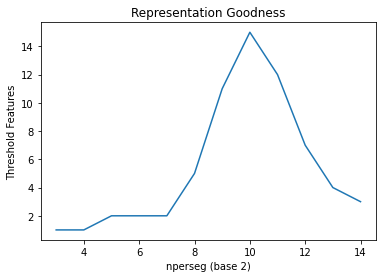

In [16]:
ps = np.arange(3, 15)
th_features = []
for p in ps:
    th_features.append(spec_rep_goodness(win_length=2**p, vis=False))
plt.figure()
plt.plot(ps, th_features)
plt.xlabel('nperseg (base 2)')
plt.ylabel('Threshold Features')
plt.title('Representation Goodness')
plt.show()

While this simple goodness manifold agrees with our visual perception of the representations, it's possible to explore higher dimensional manifolds involving more parameters, and we can analyze the performance on downstream tasks.

## Time-Frequency Reassigned Spectrograms

As we've discussed earlier, the spectrogram-based representation of acoustic signals unfortunately demands a tradeoff between spectral and temporal resolution. The time-frequency reassigned (TFR) spectrogram provides a means to achieve sharper resolutions. Here, we will explore this approach to acoustic signal representation.

Unlike the conventional STFT approach, which yields a blurred representation, the TFR method maps data
to time-frequency coordinates that are nearer to the true region of support of the analyzed signal, yielding a sharper representation of the original signal.

/home/peterbermant/.pyenv/versions/3.6.7/envs/venv/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


output_frame_count 467


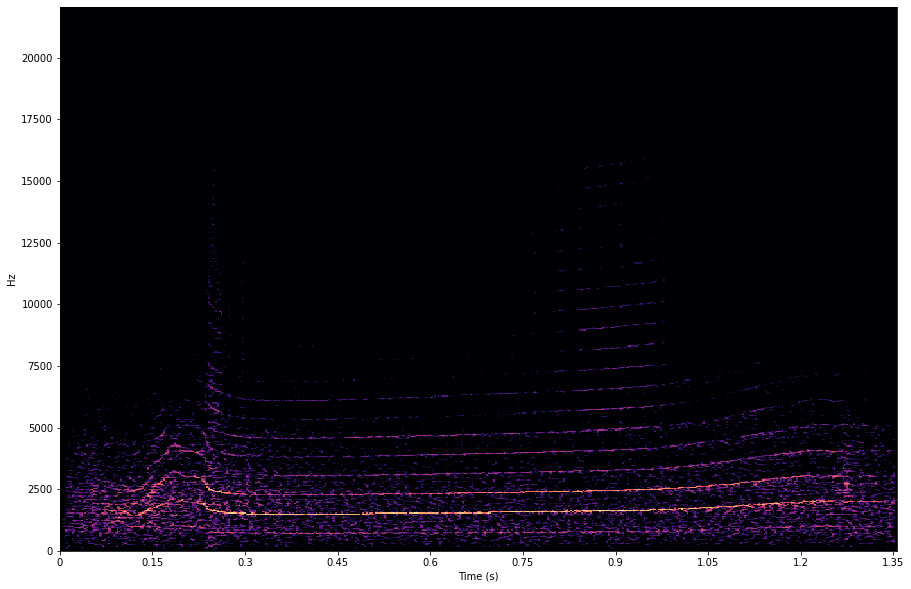

In [17]:
import tfr
import librosa.display
import warnings
warnings.simplefilter('ignore', FutureWarning)

signal_frames = tfr.SignalFrames(path_name, frame_size=1024, hop_size=128)
x_spectrogram = tfr.reassigned_spectrogram(signal_frames)
fig = plt.figure(figsize=(15,10))
librosa.display.specshow(x_spectrogram.T, x_axis="s", y_axis="linear", sr=sr_orca, hop_length=128, cmap='magma')
plt.show()

## Baseline

Here, we'll run an experiment using an open source macaque dataset to test our spectrogram representation:

In [18]:
SR = 24414
NFFT = 1024
HOP_LENGTH = None
WINDOW = scipy.signal.hanning
FMAX = 7500
DB_TH = 1e-4
RES = 128
BATCH_SIZE = 16
BUFFER_SIZE = 6000
LATENT_DIM = 128
EPOCHS = 25
MAX = 1
MIN = 0
URL = 'https://storage.googleapis.com/ml-animal-sounds-datasets/macaques_24414Hz.zip'

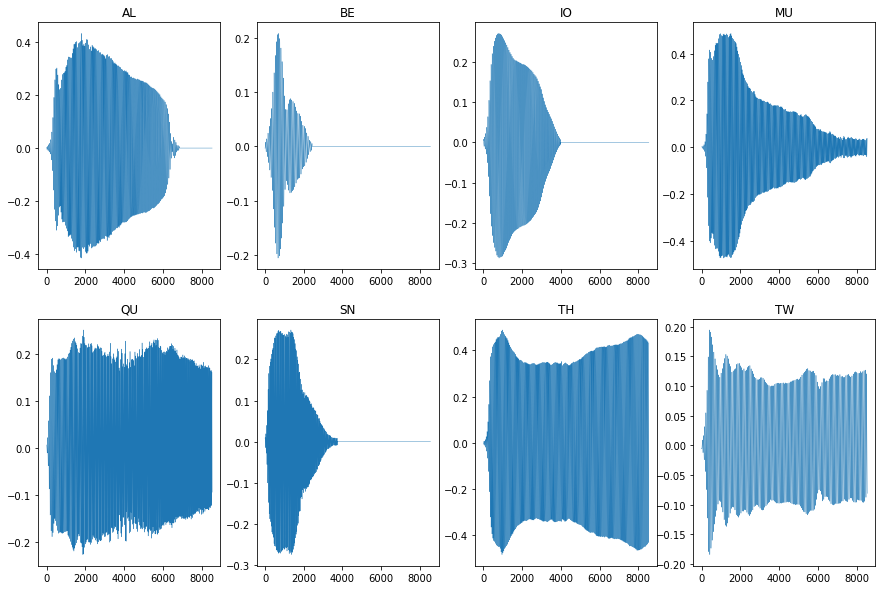

In [19]:
class LoadData(object):
    
    def __init__(self, url=URL):
        self.url = url
        
    def construct_dataframe(self):
        path = untar_data(self.url)
        wav_files = get_files(path)

        wfs = []
        labels = []
        wavs = []

        for wav in wav_files:
            call_code = re.split('/', str(wav))[-2]
            wf, _ = sf.read(wav)

            wfs.append(wf)
            labels.append(call_code)
            wavs.append(wav)

        call_dict = {l: i for i, l in enumerate(np.unique(labels))}
        call_category = [call_dict[i] for i in labels]
        data_df = pd.DataFrame({'Waveform':wfs, 'Path': wavs, 'Label': labels, 'Category': call_category})
        
        return data_df
    
    def fixed_dataframe(self):
        
        dataframe = self.construct_dataframe()
        
        mean_dur = self.get_mean_duration(dataframe)
        paths = dataframe.Path.values
        labels = dataframe.Label.values
        categories = dataframe.Category.values
        waveforms = dataframe.Waveform.values

        xs = []
        for wf in waveforms:
            x = librosa.util.fix_length(wf, mean_dur)
            xs.append(x)
        fixed_df = pd.DataFrame({'Waveform':xs, 'Path': paths, 'Label':labels, 'Category':categories})    
        return fixed_df
    
    def balanced_dataframe(self):
    
        dataframe = self.fixed_dataframe()
        balanced_df = dataframe.groupby('Category')
        balanced_df = balanced_df.apply(lambda x: x.sample(balanced_df.size().min()).reset_index(drop=True))

        return balanced_df
    
    def visualize_classes(self, dataframe, group='Label'):
        df = dataframe.groupby(group).apply(lambda x: x.sample(1))
        df = df.reset_index(drop=True)

        fig, axes = plt.subplots(2,4, figsize=(15,10))
        for i, ax in enumerate(axes.flatten()):
            ax.plot(df.Waveform.iloc[i], linewidth=0.4)
            ax.set_title(df.Label.iloc[i])
        plt.show()
    
    @staticmethod
    def get_mean_duration(dataframe):
        waveforms = dataframe.Waveform.values
        durs = []
        for wf in waveforms:
            durs.append(wf.shape[0])
        mean_dur = int(np.mean(durs))
        return mean_dur
    
loader = LoadData()
data_df = loader.balanced_dataframe()
mean_dur = loader.get_mean_duration(data_df)
loader.visualize_classes(data_df)

In [21]:
MEAN_DURATION = mean_dur
WINDOW_WIDTH = MEAN_DURATION

In [23]:
from sklearn.model_selection import train_test_split

X_numpy = np.zeros((len(data_df), MEAN_DURATION), dtype=np.float32)
for i, wf in enumerate(data_df.Waveform.values):
    X_numpy[i, :] = wf
Y=data_df.Category.values

X_train, X_test, Y_train, Y_test = train_test_split(X_numpy, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2995, 8549), (749, 8549), (2995,), (749,))

In [25]:
import tensorflow as tf

class SpecGram(tf.keras.layers.Layer):
    def __init__(self, name='spectrogram', **kwargs):
        super(SpecGram, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.spectrogram_representation(input_)

    @tf.function
    def spectrogram_representation(self, x):

        def construct_spectrogram(signal, sr=SR, nfft=NFFT, hoplength=HOP_LENGTH, win=WINDOW, db_th=DB_TH):
            if hoplength is None:
                hoplength = nfft//16

            _, _, spec = librosa.reassigned_spectrogram(y=signal, sr=sr, n_fft=nfft, hop_length=hoplength, window=win)
            spec_db = librosa.power_to_db(spec, amin=db_th)
            f_bins = librosa.core.fft_frequencies(sr=sr, n_fft=nfft)
            t_bins = np.linspace(0, len(signal)/sr, spec[0].shape[0])
            return t_bins,f_bins, spec_db

        def interp_spectrogram(spec, t, f, res=RES, fmax=FMAX):
            if fmax is None:
                fmax = np.max(f)

            interp_fx = interpolate.interp2d(t, f, spec, kind='cubic')
            ts_interp = np.linspace(np.min(t), np.max(t), res)
            freqs_interp = np.linspace(np.min(f), fmax, res)
            spec_interp = interp_fx(ts_interp, freqs_interp)
            return spec_interp, freqs_interp, ts_interp

        def generate_representation(waveform, sr=SR, nfft=NFFT, db_th=DB_TH, win=WINDOW, res=RES, fmax=FMAX):
            batch_size= waveform.shape[0]
            reps = np.zeros((batch_size, res, res))
            for n in range(batch_size):
                t, f, Sxx = construct_spectrogram(waveform[n,:], sr=sr, nfft=nfft, win=win, db_th=db_th)
                rep, _, _ = interp_spectrogram(Sxx, t, f, res, fmax)
                reps[n, :, :] = rep
            return reps.astype('float32')

        @tf.function(input_signature=[tf.TensorSpec(None, tf.float32)])
        def tf_rep(input_):
            y = tf.numpy_function(generate_representation, [input_], tf.float32)
            return y

        x = tf.cast(x, tf.float32)
        result = (tf_rep(x))
        return tf.keras.backend.reshape(result, (-1, RES, RES))

    def get_config(self):
        config = super(SpecGram, self).get_config()
        return config

    def vis_rep(self, X_examples, Y_examples):
        N_examples = X_examples.shape[0]

        def is_sqrt(x):
            sq = np.sqrt(x)
            return (sq - np.floor(sq))==0

        if ~is_sqrt(N_examples):
            raise ValueError('Choose a perfect square number of examples')
        else:
            plot_dim = int(np.sqrt(N_examples))

        reps = self.spectrogram_representation(X_examples)
        fig, axes = plt.subplots(plot_dim, plot_dim, figsize=(15, 10))
        axs = axes.flatten()
        for n in range(N_examples):
            axs[n].imshow(reps[n, :, :].numpy(), cmap='magma')
            axs[n].invert_yaxis()
            axs[n].set_xticks([])
            axs[n].set_yticks([])
            axs[n].set_title(f'Class {Y_examples[n]}')

In [27]:
class MinMaxScaler(tf.keras.layers.Layer):
    def __init__(self, name='min_max_scaler', **kwargs):
        super(MinMaxScaler, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.min_max_scaler(input_)

    @tf.function
    def min_max_scaler(self, x):
        batch, height, width = x.shape
        x = tf.cast(x, tf.float32)

        _min = tf.math.reduce_min(x, axis=2, keepdims=True, name=None)
        _min = tf.math.reduce_min(_min, axis=1, keepdims=True, name=None)

        _max = tf.math.reduce_max(x, axis=2, keepdims=True, name=None)
        _max = tf.math.reduce_max(_max, axis=1, keepdims=True, name=None)

        x_norm = (MAX - MIN) * (x - _min) / (_max - _min) + MIN
        return x_norm

    def get_config(self):
        config = super(MinMaxScaler, self).get_config()
        return config

In [28]:
class SpecBuilder(tf.keras.Model):

    def __init__(self):
        super(SpecBuilder, self).__init__()
        self.builder = self.build_spec_model()

    def build_spec_model(self):
        spec_inputs = tf.keras.Input(shape=(WINDOW_WIDTH,))
        x = SpecGram()(spec_inputs)
        x = MinMaxScaler()(x)
        outputs = tf.keras.layers.Reshape((RES, RES, 1), input_shape=(RES, RES))(x)

        spec_model = tf.keras.Model(spec_inputs, outputs, name='spec_builder')
        return spec_model

    def call(self, x):
        return self.builder(x)

/home/peterbermant/.pyenv/versions/3.6.7/envs/venv/lib/python3.6/site-packages/librosa/core/spectrum.py:718: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
/home/peterbermant/.pyenv/versions/3.6.7/envs/venv/lib/python3.6/site-packages/librosa/core/spectrum.py:878: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)


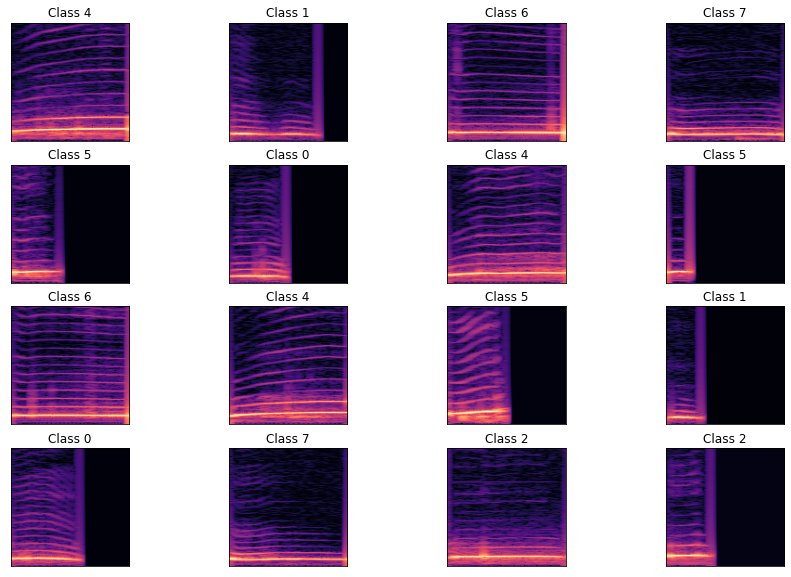

In [29]:
SpecGram().vis_rep(X_train[0:16], Y_train[0:16])

In [32]:
def build_baseline_classifier():
    inputs = tf.keras.Input(shape=(WINDOW_WIDTH,))
    x = SpecGram()(inputs)
    x = MinMaxScaler()(x)
    x = tf.keras.layers.Reshape((RES, RES, 1), input_shape=(RES, RES))(x)

    x = tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(3, 3),
                               activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(3, 3), 
                               activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

    classifier = tf.keras.Model(inputs=inputs, outputs=outputs, name='baseline_classifier')
    return classifier

baseline_model = build_baseline_classifier()
baseline_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])
baseline_model.summary()

Model: "baseline_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8549)]            0         
_________________________________________________________________
spectrogram (SpecGram)       (None, 128, 128)          0         
_________________________________________________________________
min_max_scaler (MinMaxScaler (None, 128, 128)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)

In [33]:
with tf.device('/GPU:0'):
    baseline_model.fit(X_train, Y_train,
                     batch_size=BATCH_SIZE,
                     epochs=10,
                     verbose=1,
                     validation_split=0.1)

Epoch 1/10
169/169 [==============================] - 50s 296ms/step - loss: 0.6857 - accuracy: 0.7763 - val_loss: 0.1087 - val_accuracy: 0.9767
Epoch 2/10
169/169 [==============================] - 50s 295ms/step - loss: 0.2105 - accuracy: 0.9377 - val_loss: 0.0451 - val_accuracy: 0.9900
Epoch 3/10
169/169 [==============================] - 50s 297ms/step - loss: 0.1608 - accuracy: 0.9518 - val_loss: 0.0246 - val_accuracy: 0.9900
Epoch 4/10
169/169 [==============================] - 50s 295ms/step - loss: 0.1176 - accuracy: 0.9633 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 5/10
169/169 [==============================] - 50s 296ms/step - loss: 0.0724 - accuracy: 0.9733 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 6/10
169/169 [==============================] - 50s 294ms/step - loss: 0.0919 - accuracy: 0.9718 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 7/10
169/169 [==============================] - 50s 298ms/step - loss: 0.0720 - accuracy: 0.9792 - val_loss: 0.0029 - val_ac

In [34]:
baseline_model.evaluate(X_test, Y_test)

24/24 [==============================] - 12s 481ms/step - loss: 0.0491 - accuracy: 0.9840


[0.04914155229926109, 0.9839786291122437]

# Wavelet Scattering Transforms

 This transform is constructed as a convolutional network whose filters are fixed to be wavelet and lowpass averaging filters coupled with modulus nonlinearities, and the resultant transform is invariant to translations and diffeomorphisms, which makes it suitable for CNN-based audio processing.

## Motivating the Transform

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from fastai2.vision.all import *

import librosa
from librosa.display import specshow
import soundfile as sf
import scipy.signal
from kymatio.numpy import Scattering1D
from sklearn.model_selection import train_test_split

import tensorflow as tf

import pathlib
from IPython.display import Audio
import functools
import tqdm
import time
from IPython import display

Naively, a spectrogram looks like an image, so it seems to make since to use tools designed for image processing, such as CNNs. However, a spectrogram is fundamentally different from an image, so many of the advantages of CNNs do not apply when working with spectrogram datasets.

For instance, CNNs are purposefully designed to capitalize on invariances that characterize image data. These invariances include (1) rotation, (2) scale, (3) translation, and (4) reflection invariance. What does this mean in practice? Well, let's consider the following image.

In [36]:
def load_image(img_path):
    from PIL import Image
    img = Image.open(img_path)
    return img

def show_image(img):
    plt.figure(figsize=(6,8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

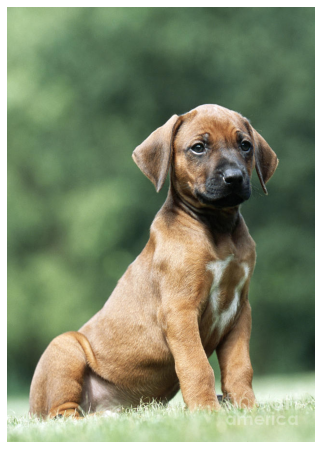

In [37]:
I = load_image('08_Extras/rhodesian_puppy.jpg')
show_image(I)

What happens if we transform the image?

In [39]:
def rotate_image(img, D):
    import scipy.ndimage
    img_D = scipy.ndimage.rotate(img, D, reshape=False)
    return img_D

def zoom_image(img, Nx0, Nx1):
    import scipy.ndimage
    Nx = (Nx0, Nx1, 1)
    img_Nx = scipy.ndimage.zoom(img, Nx)
    dim0 = np.array(img).shape[0]
    dim1 = np.array(img).shape[1]
    cut0 = dim0 - int(dim0 / Nx0)
    cut1 = dim1 - int(dim1 / Nx1)
    img_Nx = img_Nx[cut0:cut0+dim0, cut1:cut1+dim1, :]
    return img_Nx

def shift_image(img, shift_X, shift_Y):
    import scipy.ndimage
    shift = (shift_Y, shift_X, 0)
    img_shift = scipy.ndimage.shift(img, shift)
    return img_shift

def reflect_image(img, axis='X'):
    from PIL import ImageOps
    if axis == 'X':
        img_ref = ImageOps.mirror(img)
    else:
        img_ref = ImageOps.flip(img)
    return img_ref

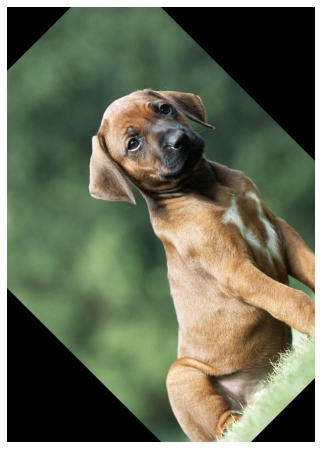

In [40]:
I_45 = rotate_image(I, 45)
show_image(I_45)

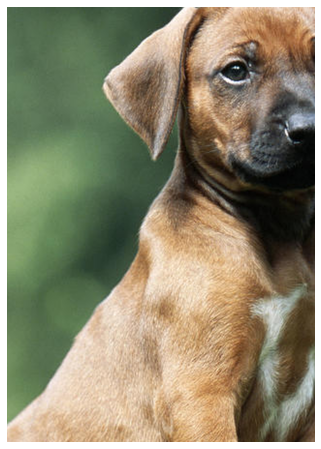

In [41]:
I_2x = zoom_image(I, 2,2)
show_image(I_2x)

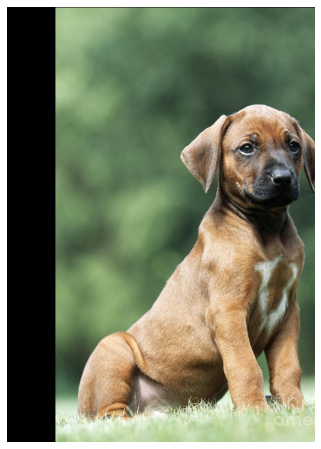

In [42]:
img_100_1 = shift_image(I, 100, 1)
show_image(img_100_1)

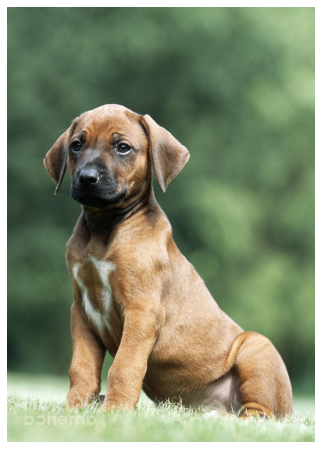

In [43]:
img_mirror = reflect_image(I, 'X')
show_image(img_mirror)

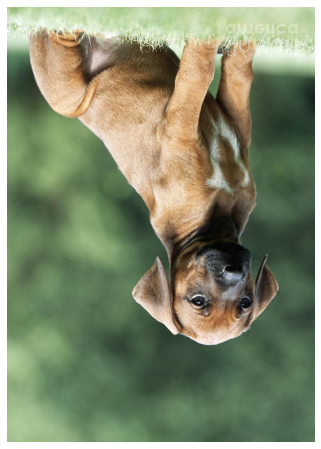

In [45]:
img_flip= reflect_image(I, 'Y')
show_image(img_flip)

We are clearly able to see the puppy regardless of the transformation. This is because image datasets exhibit invariance when performing a number of transformations. CNNs make use of this invariance to carry out classification tasks with a high degree of robustness. This is also why it is possible to use simple transformations to perform data augmentation with image data.

However, these fundamental invariances simply do not apply to audio spectrogram 'image' datasets, primarily due to the inherent meaning of the axes. The x-axis has temporal significance, and the y-axis has spectral significance, so some of the above transformations are not necessarily defined operations when dealing with acoustic data. What does this mean? Let's consider a chirp.

In [47]:
chirp_low_high = librosa.chirp(440, 5440, sr=22050, duration=4)

In [49]:
def generate_spectrogram(signal, sr=22050, low_lim=0, high_lim=22050//2):
    S = librosa.stft(signal)
    return S

def draw_spectrogram(S, title, sr=22050, low_lim=0, high_lim=22050//2):
    D = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    librosa.display.specshow(D, y_axis='linear', fmax=sr//2, x_axis='time')
    plt.title(title)
    plt.ylim([low_lim, high_lim])
    plt.colorbar()
    
def invert_spectrogram(S):
    A = librosa.istft(S)
    return A

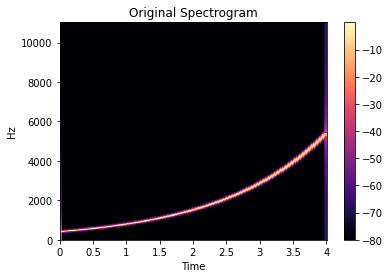

In [51]:
signal = chirp_low_high
S = generate_spectrogram(signal)
draw_spectrogram(S, 'Original Spectrogram')
A = invert_spectrogram(S)
display.Audio(A, rate=22050)

In [52]:
def rotate_spectrogram(S):
    S_90 = np.rot90(S)
    return S_90

def zoom_spectrogram(S, Nx0, Nx1):
    import scipy.ndimage
    Nx = (Nx0, Nx1)
    S_Nx = scipy.ndimage.zoom(np.real(S), Nx) + 1j*scipy.ndimage.zoom(np.imag(S), Nx)
    dim0 = S.shape[0]
    dim1 = S.shape[1]
    cut0 = dim0 - int(dim0 / Nx0)
    cut1 = dim1 - int(dim1 / Nx1)
    S_Nx = S_Nx[cut0:cut0+dim0, cut1:cut1+dim1]
    return S_Nx

def shift_spectrogram(S, shift_X, shift_Y):
    import scipy.ndimage
    shift = (shift_Y, shift_X)
    S_XY = scipy.ndimage.shift(np.real(S), shift) + 1j*scipy.ndimage.shift(np.imag(S), shift)
    return S_XY

def reflect_spectrogram(S, axis='X'):
    if axis == 'X':
        S_ref = np.fliplr(S)
    else:
        S_ref = np.flipud(S)
    return S_ref

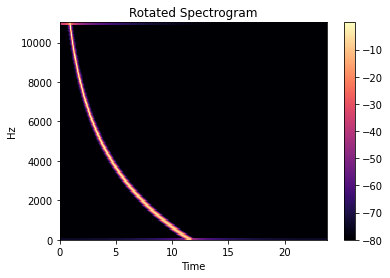

In [53]:
S_90 = rotate_spectrogram(S)
draw_spectrogram(S_90, 'Rotated Spectrogram')
A_90 = invert_spectrogram(S_90)
display.Audio(A_90, rate=22050)

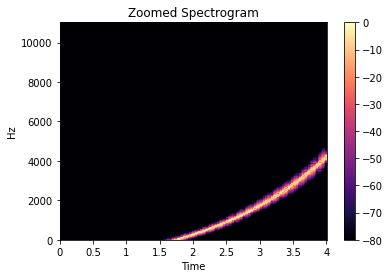

In [54]:
S_12x = zoom_spectrogram(S, 1.2, 1.2)
draw_spectrogram(S_12x, 'Zoomed Spectrogram')
A_12x = invert_spectrogram(S_12x)
display.Audio(A_12x, rate=22050)

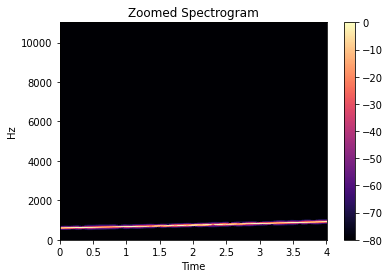

In [55]:
S_1x_6x = zoom_spectrogram(S, 1, 6)
draw_spectrogram(S_1x_6x, 'Zoomed Spectrogram')
A_1x_6x = invert_spectrogram(S_1x_6x)
display.Audio(A_1x_6x, rate=22050)

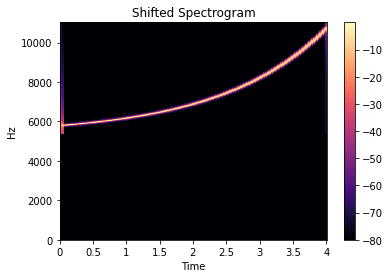

In [56]:
S_1_500 = shift_spectrogram(S, 1, 500)
draw_spectrogram(S_1_500, 'Shifted Spectrogram')
A_1_500 = invert_spectrogram(S_1_500)
display.Audio(A_1_500, rate=22050)

In [57]:
wf, sr = librosa.load('08_Extras/emordnilap.m4a', sr=None)
display.Audio(wf, rate=sr)

/home/peterbermant/.pyenv/versions/3.6.7/envs/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


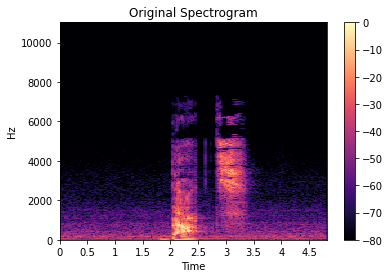

In [58]:
S = generate_spectrogram(wf)
draw_spectrogram(S, 'Original Spectrogram')
A = invert_spectrogram(S)
display.Audio(A, rate=sr)

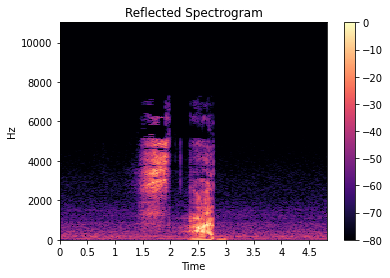

In [59]:
S_mirror = reflect_spectrogram(S, 'X')
draw_spectrogram(S_mirror, 'Reflected Spectrogram')
A_mirror = invert_spectrogram(S_mirror)
display.Audio(A_mirror, rate=sr)

After having established the need for an invariant transform, we'll take a look at a practical implementation of the scattering wavelet transform using the macaque coo call classification dataset.

In [60]:
class Normalizer(tf.keras.layers.Layer):
    
    def __init__(self, name='normalizer', **kwargs):
        super(Normalizer, self).__init__(name=name, **kwargs)
        
    def call(self, input_):
        return self.normalize(input_)
        
    @tf.function
    def normalize(self, x):
        batch, samples = x.shape
        _max = tf.math.reduce_max(tf.abs(x), axis=1, keepdims=True, name=None)
        x_norm = x / _max
        return x_norm
         
normalizer = Normalizer()

In [61]:
X_train_norm, X_test_norm = Normalizer()(X_train).numpy(), Normalizer()(X_test).numpy()

Now that we have our normalized input data, we can proceed to carry out a 1D scattering transform. We need to specify four parameters: (1) T is the number of elements in the time series; (2) J (or 2^J) represents the averaging, or maximum, scale, which is essentially the lowest frequencies to be resolved; (3) Q denotes the number of wavelets per octave; and (4) log_eps is an additive constant to prevent the logarithm from blowing up.

In [62]:
T = 8549
J = 6
Q = 16
log_eps = 1e-6

In [63]:
scattering = Scattering1D(J, T, Q)

In [64]:
Sx_train = np.zeros((X_train.shape[0],221,133), dtype='float32')
import tqdm
for i in tqdm.tqdm(range(X_train.shape[0])):
    Sx = scattering(X_train_norm[i]).astype('float32')
    Sx = Sx[1:, :]
    Sx = np.log10(np.abs(Sx) + log_eps)
    Sx_train[i] = Sx

100%|██████████| 2995/2995 [05:31<00:00,  9.03it/s]


In [65]:
Sx_test = np.zeros((X_test.shape[0],221,133), dtype='float32')
import tqdm
for i in tqdm.tqdm(range(X_test.shape[0])):
    Sx = scattering(X_test_norm[i]).astype('float32')
    Sx = Sx[1:, :]
    Sx = np.log10(np.abs(Sx) + log_eps)
    Sx_test[i] = Sx

100%|██████████| 749/749 [01:23<00:00,  8.98it/s]


In [66]:
Sx_train1 = Sx_train[:, 0:63, :]
Sx_train2 = Sx_train[:, 63:, :]
Sx_train1.shape,Sx_train2.shape

((2995, 63, 133), (2995, 158, 133))

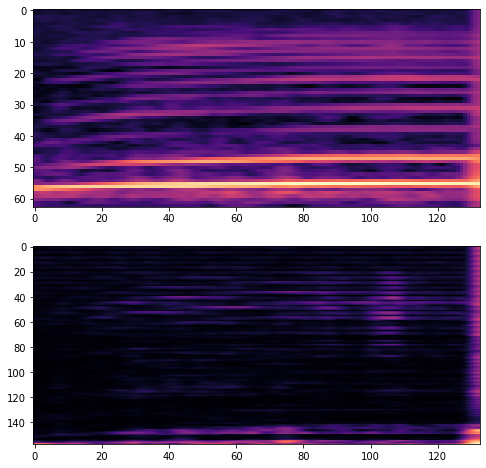

In [67]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.imshow(Sx_train1[0], aspect='auto', cmap='magma')
plt.subplot(2, 1, 2)
plt.imshow(Sx_train2[0], aspect='auto', cmap='magma')

In [68]:
class MinMaxScaler(tf.keras.layers.Layer):
    def __init__(self, name='min_max_scaler', **kwargs):
        super(MinMaxScaler, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.min_max_scaler(input_)

    @tf.function
    def min_max_scaler(self, x):
        batch, height, width = x.shape
        x = tf.cast(x, tf.float32)

        _min = tf.math.reduce_min(x, axis=2, keepdims=True, name=None)
        _min = tf.math.reduce_min(_min, axis=1, keepdims=True, name=None)

        _max = tf.math.reduce_max(x, axis=2, keepdims=True, name=None)
        _max = tf.math.reduce_max(_max, axis=1, keepdims=True, name=None)

        x_norm = (MAX - MIN) * (x - _min) / (_max - _min) + MIN
        return x_norm

    def get_config(self):
        config = super(MinMaxScaler, self).get_config()
        return config

In [69]:
def build_dual_cnn():
    inputs1 = tf.keras.Input(shape=(63,133))
    x1 = MinMaxScaler(name='minmax1')(inputs1)
    x1 = tf.keras.layers.Reshape((63,133, 1), input_shape=(63,133))(x1)
    x1 = tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(3, 3),
                               activation='relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(3, 3), 
                               activation='relu')(x1)
    x1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x1)
    x1 = tf.keras.layers.Dropout(0.25)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Dense(128, activation='relu')(x1)
    x1 = tf.keras.layers.Dropout(0.5)(x1)
    
    inputs2 = tf.keras.Input(shape=(158,133))
    x2 = MinMaxScaler(name='minmax2')(inputs2)
    x2 = tf.keras.layers.Reshape((158,133, 1), input_shape=(158,133))(x2)
    x2 = tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(3, 3),
                               activation='relu')(x2)
    x2 = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(3, 3), 
                               activation='relu')(x2)
    x2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = tf.keras.layers.Dropout(0.25)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
    x2 = tf.keras.layers.Dropout(0.5)(x2)
    
    x = tf.keras.layers.Concatenate()([x1, x2])
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    
    outputs = tf.keras.layers.Dense(8, activation='softmax')(x)
    
    classifier = tf.keras.Model(inputs=[inputs1, inputs2], outputs=outputs, name='dual_classifier')
    return classifier

dual_model = build_dual_cnn()
dual_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
dual_model.summary()

Model: "dual_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 63, 133)]    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 158, 133)]   0                                            
__________________________________________________________________________________________________
minmax1 (MinMaxScaler)          (None, 63, 133)      0           input_3[0][0]                    
__________________________________________________________________________________________________
minmax2 (MinMaxScaler)          (None, 158, 133)     0           input_4[0][0]                    
____________________________________________________________________________________

In [70]:
with tf.device('GPU:0'):
    dual_model.fit([Sx_train1, Sx_train2], Y_train,
              epochs=20,
              batch_size=128,
              validation_split=0.1,
              verbose=1)

Epoch 1/20
22/22 [==============================] - 11s 513ms/step - loss: 0.7883 - accuracy: 0.7306 - val_loss: 0.1239 - val_accuracy: 0.9667
Epoch 2/20
22/22 [==============================] - 10s 454ms/step - loss: 0.1900 - accuracy: 0.9429 - val_loss: 0.0654 - val_accuracy: 0.9767
Epoch 3/20
22/22 [==============================] - 10s 456ms/step - loss: 0.1137 - accuracy: 0.9696 - val_loss: 0.0273 - val_accuracy: 0.9933
Epoch 4/20
22/22 [==============================] - 10s 454ms/step - loss: 0.0696 - accuracy: 0.9785 - val_loss: 0.0161 - val_accuracy: 0.9967
Epoch 5/20
22/22 [==============================] - 10s 453ms/step - loss: 0.0448 - accuracy: 0.9866 - val_loss: 0.0117 - val_accuracy: 0.9933
Epoch 6/20
22/22 [==============================] - 10s 454ms/step - loss: 0.0330 - accuracy: 0.9885 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 7/20
22/22 [==============================] - 10s 455ms/step - loss: 0.0363 - accuracy: 0.9896 - val_loss: 0.0045 - val_accuracy: 1.0000

In [71]:
Sx_test1 = Sx_test[:, 0:63, :]
Sx_test2 = Sx_test[:, 63:, :]
Sx_test1.shape,Sx_test2.shape

((749, 63, 133), (749, 158, 133))

In [72]:
dual_model.evaluate([Sx_test1, Sx_test2], Y_test)

24/24 [==============================] - 1s 55ms/step - loss: 0.0314 - accuracy: 0.9907


[0.03135127201676369, 0.9906542301177979]

## Deep-Learned Approach

In [73]:
from IPython.display import Video

Video('07_Animations/MacaqueGAIA.mp4')

In [74]:
Video('07_Animations/MacaqueLatentSpaceTSNE.mp4')

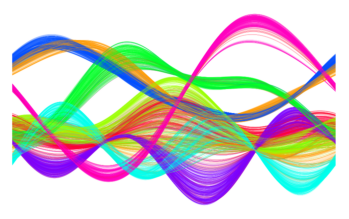

In [77]:
I = load_image('07_GON/GON_Representation.PNG')
show_image(I)

# Hilbert Huang Transform

There are a number of alternatives that we explore in the representation toolkit. One of these is the Hilbert Huang transform, which has often been used for transient signals. It might also be applicable when considering the cocktail party problem, as described in [Single Channel speech separation based on empirical mode decomposition and Hilbert Transform](https://ieeexplore.ieee.org/document/7954778). Here we'll simply provide a couple of examples.

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from PyEMD import EMD
from scipy.signal import hilbert
from scipy import interpolate

In [81]:
file = 'data/WatkinsPMacro.wav'
wf, sr_sw = sf.read(file)
signal_sw = wf[25000:45000]
time_sw = np.linspace(0,len(signal_sw)/sr_sw,len(signal_sw))

In [82]:
path_name = '../../.fastai/data/orchive-dataset.tar/call-catalog-xsilence/N01/A36-N01-062802-D004-12218.aiff'
signal_orca, sr_orca = sf.read(path_name)
time_orca = np.linspace(0,len(signal_orca)/sr_orca,len(signal_orca))

In [83]:
labels = ['Sperm Whale', 'Orca']
signals = [signal_sw, signal_orca]
times = [time_sw, time_orca]
srs = [sr_sw, sr_orca]

In [84]:
emd = EMD()
imfs_sw_orca = [emd(signal_sw), emd(signal_orca)]

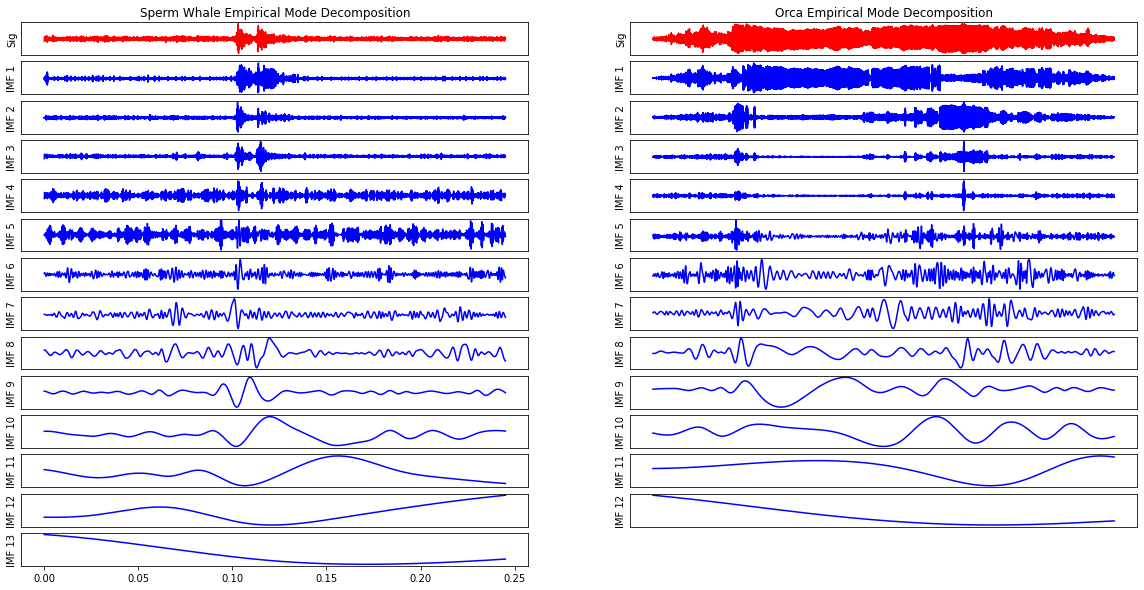

In [85]:
n_max = 13
fig, axs = plt.subplots(n_max+1, 2, figsize=(20,10))
for idx, imfs in enumerate(imfs_sw_orca):
    label = labels[idx]
    signal = signals[idx]
    time = times[idx]
    
    axs[0, idx].plot(time, signal, color='r')
    axs[0, idx].set_xticks([])
    axs[0, idx].set_yticks([])
    axs[0, idx].set_ylabel('Sig')
    axs[0, idx].set_title(f'{label} Empirical Mode Decomposition')
    
    try:
        for i in range(n_max):
            axs[i+1, idx].plot(time, imfs[i,:], color='blue')
            axs[i+1, idx].set_ylabel(f'IMF {i+1}')
            axs[i+1, idx].set_yticks([])
            if i < n_max-1:
                axs[i+1, idx].set_xticks([])
            if i == n_max:
                axs[i+1, idx].set_xlabel('Time (s)')
    except IndexError:
        fig.delaxes(axs[-1][1])
plt.show()

In [86]:
class HHT(object):
    
    def __init__(self, signal, time, fs):
        self.signal = signal
        self.time = time
        self.fs = fs
        
    def emd(self):
        calc_emd = EMD()
        imfs = calc_emd(self.signal)
        return imfs
    
    def ht(self, t_res=128, f_res=256, ylim=20000, amin=1e-2):
        s = self.signal
        t = self.time
        N = len(t)
        Ts = 1 / self.fs
        
        t_bins = np.linspace(0, np.max(t), t_res)
        t_dig = np.digitize(t, t_bins)-1
        
        f_bins = np.linspace(0, 16, f_res)
        f_bins = 2**f_bins
        
        imfs = self.emd()
        K = imfs.shape[0]
        
        HS = np.zeros((t_res, f_res))
        for i in range(K):
            x = imfs[i, :]

            H = hilbert(x)
            H_imag = H.imag
            H_amp = np.abs(H)

            dH_imag = np.diff(H_imag)
            dH_imag = np.insert(dH_imag, len(dH_imag), dH_imag[-1])

            dx = np.diff(x)
            dx = np.insert(dx, len(dx), dx[-1])

            w = (x*dH_imag - H_imag*dx) / (H_amp**2)
            freq = w*self.fs / (2*np.pi)

            f_dig = np.digitize(freq, f_bins)

            for idx in range(N):
                if f_dig[idx] < f_res:
                    HS[t_dig[idx], f_dig[idx]] += H_amp[idx]

        HS_dB = 20*np.log10(HS + amin)
        
        tt, ff = np.meshgrid(t_bins, f_bins)
        
        return tt, ff, HS_dB
    
    def interp_rep(self, ts, fs, hs, n_points=1000, ylim=20000):
        f = interpolate.RectBivariateSpline(ts, fs, hs)

        t_interp = np.linspace(0, ts[-1], n_points)
        f_interp = np.linspace(0, fs[-1], n_points)

        hs_interp = f(t_interp, f_interp)

        tt, ff = np.meshgrid(t_interp, f_interp)
        return tt, ff, hs_interp
    
    def plot_rep(self, t_mesh, f_mesh, HS_arr, ylim=20000, interp=False, vis_details=True, vis=True):
        
        if interp:
            t_mesh, f_mesh, HS_arr = self.interp_rep(t_mesh[0, :], f_mesh[:, 0], HS_arr, ylim=ylim)
        fig = plt.figure()
        plt.pcolormesh(t_mesh, f_mesh, HS_arr.T, cmap='magma')
        plt.ylim([0, ylim])
        if vis_details:
            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (Hz)')
            plt.title('Hilbert Huang Spectrum')
        else:
            plt.xticks([])
            plt.yticks([])
        if vis:
            plt.show()

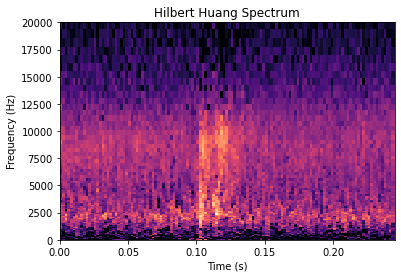

In [87]:
hht_sw = HHT(signal_sw, time_sw, sr_sw)
imfs_sw = hht_sw.emd()
tt_sw, ff_sw, HS_dB_sw = hht_sw.ht()
hht_sw.plot_rep(tt_sw, ff_sw, HS_dB_sw)

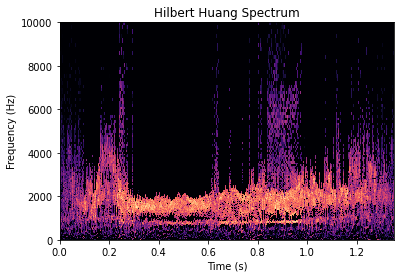

In [88]:
hht_orca = HHT(signal_orca, time_orca, sr_orca)
imfs_orca = hht_orca.emd()
tt_orca, ff_orca, HS_dB_orca = hht_orca.ht(t_res=512, f_res=512)
hht_orca.plot_rep(tt_orca, ff_orca, HS_dB_orca, ylim=10000)